# Part 2: Lyric to predict Artist - Transfer Learning - 25%

## connect to my google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## import the libraries needed


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import pickle
import tensorflow_hub as hub

## global parameters


In [6]:
WORKDIR = "/content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/"
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

## create the train set and save the test set for later

lyrics_df shape before: (250197, 5)


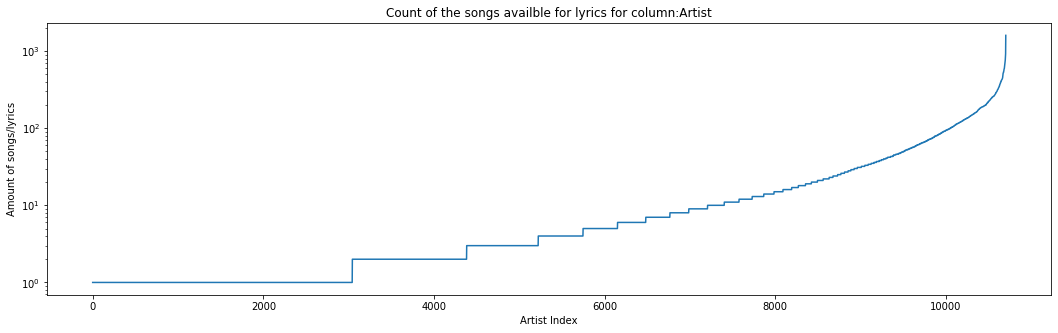

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


lyrics_df shape after: (81334, 6)


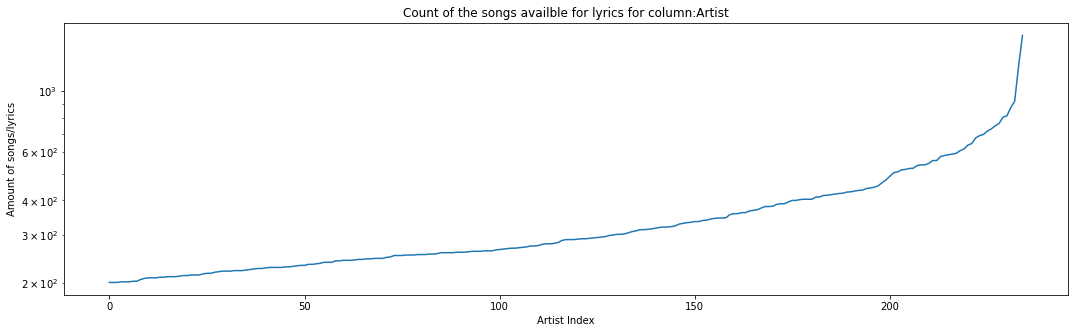

In [12]:
def chart_the_artists(df, column="Artist"):
    plt.figure(figsize=(18, 5))
    plt.title("Count of the songs availble for lyrics for column:" + column)
    artists = df[column].value_counts().sort_values().reset_index()
    plt.plot(artists.index, artists[column])
    plt.xlabel('Artist Index')
    plt.ylabel('Amount of songs/lyrics')
    plt.yscale("log")
    plt.show()
    return artists

def run_me_once():
    """put away a separate test set so I can try it out on download models in 
    the future. This test set will have the same proportions as the whole 
    dataset in terms of Genres.Test set will be 10% of the dataset
    
    only allowing artists which have more than 200 songs
    """
    lyrics_df = pd.read_csv(
        os.path.join(WORKDIR, 'train.csv'))
    lyrics_df = lyrics_df.query('Language == "en"') # only concerned with english data

    print("lyrics_df shape before:", lyrics_df.shape)
    chart_the_artists(lyrics_df, column="Artist")
    lyrics_df['Artist_frequency'] = lyrics_df['Artist'].map(lyrics_df['Artist'].value_counts())
    lyrics_df = lyrics_df[lyrics_df['Artist_frequency'] > 200] 

    print("lyrics_df shape after:", lyrics_df.shape)
    chart_the_artists(lyrics_df, column="Artist")

    # Initial train and test split.
    train_df, test_df = train_test_split(
        lyrics_df,
        test_size=0.1,
        stratify=lyrics_df["Artist"].values,
        shuffle=True
    )
    train_df.to_csv(os.path.join(WORKDIR, 'train_df_task2.csv'))
    test_df.to_csv(os.path.join(WORKDIR, 'test_df_task2.csv'))

run_me_once()

function to get the test set

In [7]:
def give_me_the_test_set():
  test_df = pd.read_csv(os.path.join(WORKDIR, 'test_df_task2.csv'))
  test_df = test_df.astype('string')
  with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
      categories = pickle.load(f)
  test_df["Artist"] = pd.Categorical(test_df["Artist"], categories=categories)
  test_lyrics = test_df["Lyrics"].to_numpy()
  test_artists = test_df["Artist"].cat.codes.to_numpy()
  return test_lyrics, test_artists
    

In [8]:
test_lyrics, test_artists = give_me_the_test_set()
print(test_lyrics.shape, test_artists.shape)

(8134,) (8134,)


function to get the training data

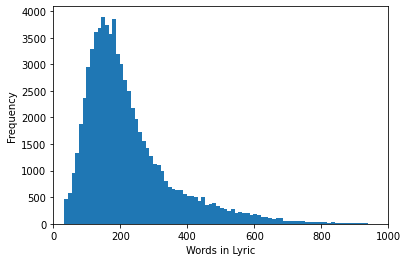

Artist.cat.categories: Index(['311', '50 cent', 'ac dc', 'adam lambert', 'aerosmith', 'afi', 'akon',
       'alanis morissette', 'alice cooper', 'alicia keys',
       ...
       'van morrison', 'vanessa carlton', 'waylon jennings', 'weezer',
       'westlife', 'whitesnake', 'whitney houston', 'willie nelson',
       'wiz khalifa', 'xzibit'],
      dtype='object', length=235)
Done


In [15]:
train_df = pd.read_csv(
    os.path.join(WORKDIR, 'train_df_task2.csv'))
# process the train_df
train_df = train_df.astype('string')
train_df = train_df[~train_df['Lyrics'].isnull()] # remove the ones with <NA> lyrics

# executive decision #1 remvoing the lyrics which are shorter than 30 words
# it does't seem like a song to me, plus hard to evaluate and my skew my model
# https://www.mentalfloss.com/article/19005/music-7-songs-fewer-35-words
# says You Are So Beautiful by Joe Cocker, Rat Charles etc. is 31 words, so making my threshold 31
train_df = train_df[~train_df["Lyrics"].str.split(" ").apply(lambda x : len(x) < 32)]

# Visualise the Lyrics column in term of words
train_df["Lyrics"].str.split(" ").apply(len).describe()
train_df["Lyrics"].str.split(" ").apply(len).plot.hist(bins=250, xlim=(0,1000))
plt.xlabel('Words in Lyric')
plt.show()

# we will need the order of the cateogries again when fetching the model
# train_df["Artist_simple"] = train_df["Artist_simple"].astype("category")
train_df["Artist"] = train_df["Artist"].astype("category")
print("Artist.cat.categories:", train_df["Artist"].cat.categories)
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'wb') as f:
    pickle.dump(train_df["Artist"].cat.categories.to_list(), f)

# using the vocab from Task1
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
    
    
training_df, validation_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["Artist"].values,
    shuffle=True
)

train_lyrics = training_df["Lyrics"].to_numpy()
train_artists = training_df["Artist"].cat.codes.to_numpy()

val_lyrics = validation_df["Lyrics"].to_numpy()
val_artists = validation_df["Artist"].cat.codes.to_numpy()

with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'wb') as f:
    pickle.dump([train_lyrics, train_artists, val_lyrics, val_artists], f)
print("Done")


In [16]:
train_df.head(10)

Unnamed: 0              Artist                              Song Genre  \
0      76728   far east movement       rocketeer (feat bruno mars)   Pop   
1      57827            the band                     move to japan   Pop   
2      17254      elvis costello  waiting for the end of the world  Rock   
3     144887  the rolling stones               street fighting man  Rock   
4      58475         the beatles                              junk  Rock   
5     184563       sarah vaughan   just one of those things (live)  Jazz   
6     168263         rod stewart                              this  Rock   
7      79869   justin timberlake                    higher, higher   Pop   
8      14006         david bowie                             kooks  Rock   
9     238730        neil diamond                   once in a while  Rock   

  Language                                             Lyrics Artist_frequency  
0       en  Here we go, come with me
There's a world out t...              223  
1       en  Well, I'm starin' at my Sony, a-drinkin' Kirun...              370  
2       en  The man from the television crawled into the t...              920  
3       en  Everywhere I hear the sound of marching, charg...              813  
4       en  Motorcars, handlebars, bicycles for two
Broken...              636  
5       en  As dorothy parker once said
To her boyfriend, ...              345  
6       en  Down by law, on Baker Street 
Lay your head ba...              696  
7       en  Uh, stress is cruel, fame's a lie
But you're s...              358  
8       en  Will you stay in our Lovers' Story
If you stay...              546  
9       en  Once in a while I would call asking lonely to ...              430

Number of rows in training set: 65404
Number of rows in validation set: 7268
Number of rows in test set: 8134


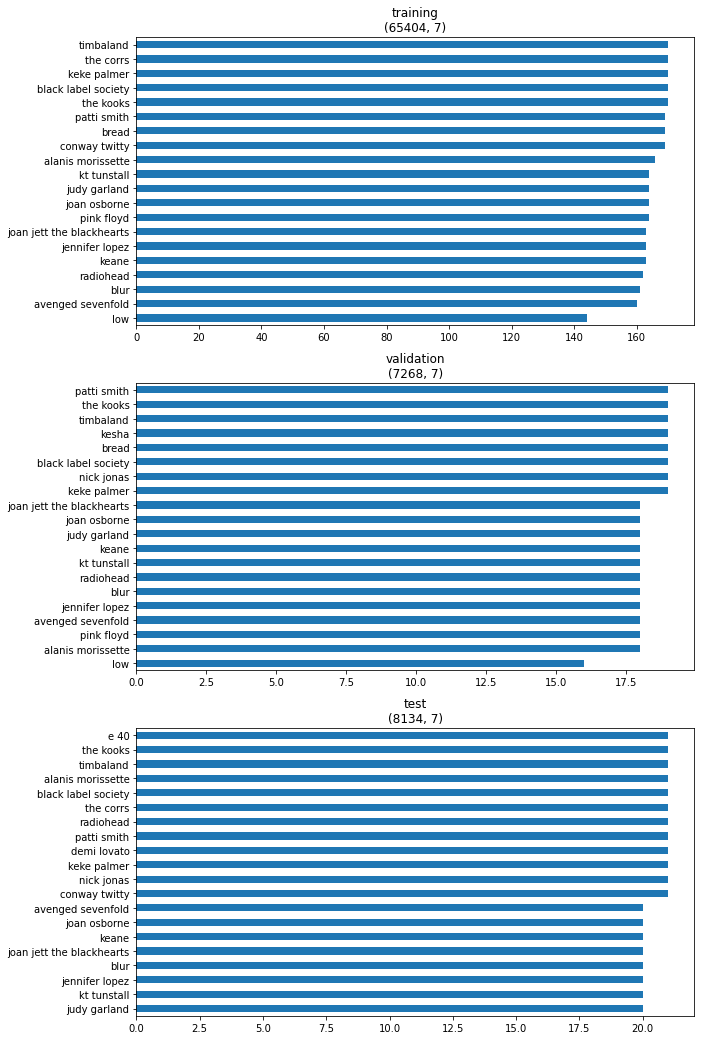

In [17]:
test_df = pd.read_csv(os.path.join(WORKDIR, 'test_df_task2.csv'))
print(f"Number of rows in training set: {len(training_df)}")
print(f"Number of rows in validation set: {len(validation_df)}")
print(f"Number of rows in test set: {len(test_df)}")
plt.figure(figsize=(10, 18))
names = ["training", "validation", "test"]
for i, df in enumerate([training_df, validation_df, test_df]):
    ax = plt.subplot(3, 1, i + 1)
    plt.title(names[i] +"\n" +str(df.shape))
    df["Artist"].value_counts().sort_values().head(20).plot(kind = 'barh')
plt.show()


### Genre proportions in the split data sets

Number of rows in training set: 65404
Number of rows in validation set: 7268
Number of rows in test set: 8134


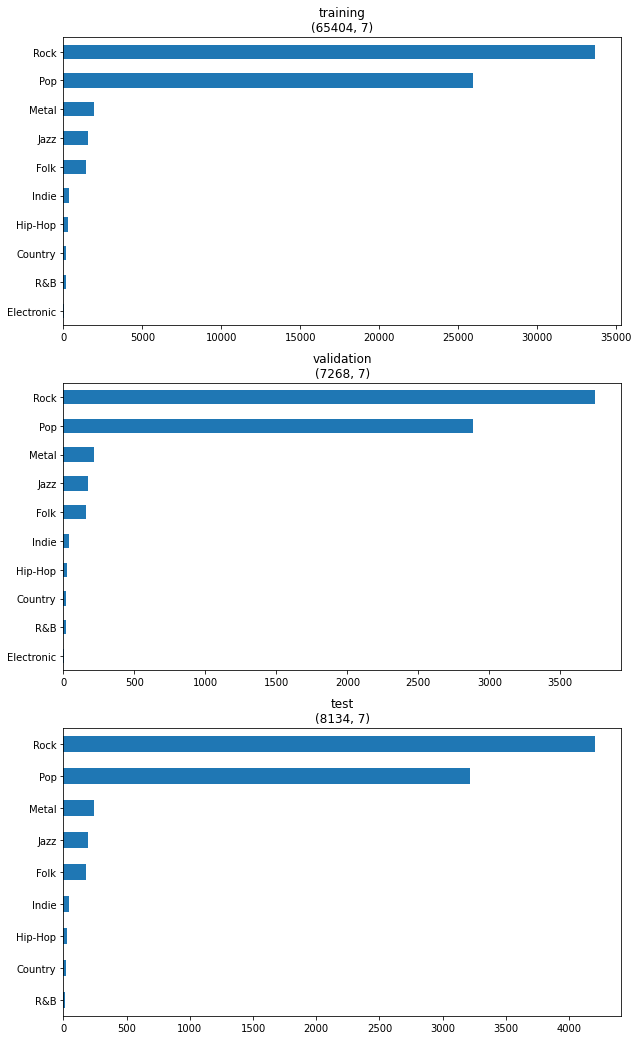

In [18]:
test_df = pd.read_csv(os.path.join(WORKDIR, 'test_df_task2.csv'))
print(f"Number of rows in training set: {len(training_df)}")
print(f"Number of rows in validation set: {len(validation_df)}")
print(f"Number of rows in test set: {len(test_df)}")
plt.figure(figsize=(10, 18))
names = ["training", "validation", "test"]
for i, df in enumerate([training_df, validation_df, test_df]):
    ax = plt.subplot(3, 1, i + 1)
    plt.title(names[i] +"\n" +str(df.shape))
    df["Genre"].value_counts().sort_values().head(20).plot(kind = 'barh')
plt.show()

# 1. Model 5 from Task 1 (best pre-trained, Embedding, glove)
 

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 200, 100)          1000200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,034,898
Trainable params: 0
Non-train

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 88s 159ms/step - loss: 7.3968 - accuracy: 0.0062 - val_loss: 5.4596 - val_accuracy: 0.0062
Epoch 2/10
510/511 [============================>.] - ETA: 0s - loss: 5.4599 - accuracy: 0.0058
Epoch 2: val_loss did not improve from 5.45958
511/511 [==============================] - 10s 20ms/step - loss: 5.4599 - accuracy: 0.0058 - val_loss: 5.4596 - val_accuracy: 0.0063
Epoch 3/10
508/511 [============================>.] - ETA: 0s - loss: 5.4597 - accuracy: 0.0054
Epoch 3: val_loss did not improve from 5.45958
511/511 [==============================] - 10s 19ms/step - loss: 5.4597 - accuracy: 0.0054 - val_loss: 5.4596 - val_accuracy: 0.0063
Epoch 4/10
509/511 [============================>.] - ETA: 0s - loss: 5.4596 - accuracy: 0.0054
Epoch 4: val_loss did not improve from 5.45958
511/511 [==============================] - 10s 19ms/step - loss: 5.4596 - accuracy: 0.0054 - val_loss: 5.4596 - val_accuracy: 0.0063
Epoch 5/10
508/511 [==================

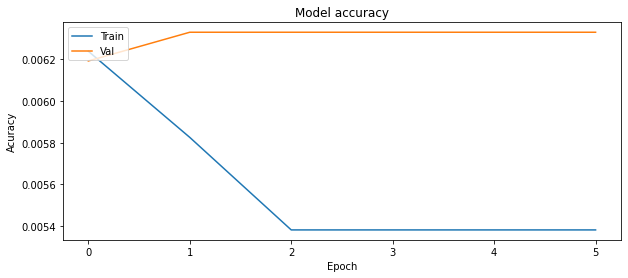

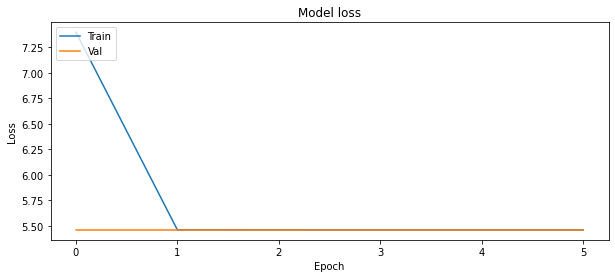

255/255 [==============================] - 3s 10ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
                                 precision    recall  f1-score   support

                            311       0.00      0.00      0.00        22
                        50 cent       0.00      0.00      0.00        52
                          ac dc       0.00      0.00      0.00        22
                   adam lambert       0.00      0.00      0.00        28
                      aerosmith       0.00      0.00      0.00        27
                            afi       0.12      0.05      0.07        21
                           akon       0.00      0.00      0.00        68
              alanis morissette       0.00      0.00      0.00        21
                   alice cooper       0.00      0.00      0.00        62
                    alicia keys       0.00      0.00      0.00        31
                   a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_fromtask1_model_5"

def print_model_details(model):
  for layer in model.layers:
      print(
          f"layer:{layer.name} ({layer.__class__.__name__})[trainable:{layer.trainable}]") 
      print("    weights:", len(layer.weights))
      print("    trainable_weights:", len(layer.trainable_weights))
      print("    non_trainable_weights:", len(layer.non_trainable_weights))
      print("    count_params:", layer.count_params())

base_name = "train_model_LSTM_with_embedding_pretrained_glove"
base_model = tf.keras.models.load_model(os.path.join(WORKDIR, base_name))

# Freeze base model
base_model.trainable = False
base_model.summary()
print_model_details(base_model)



# Create new model on top.
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = base_model(inputs, training=False)
outputs = tf.keras.layers.Dense(235)(x)
model = tf.keras.Model(inputs, outputs)


model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
print_model_details(model)
    
history = model.fit(x=train_lyrics,
                    y=train_artists,
                    validation_data=(val_lyrics, val_artists), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))

test_lyrics, test_artists = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_artists,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_artists, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_artists, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_artists, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_artists, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_artists, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_artists, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())



## Using more layers to train a better model (adding bidirectional_1 and dense_40 to training)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 200, 100)          1000200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,034,898
Trainable params: 34,698
Non-

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 84s 157ms/step - loss: 5.3485 - accuracy: 0.0268 - val_loss: 5.2085 - val_accuracy: 0.0366
Epoch 2/10
509/511 [============================>.] - ETA: 0s - loss: 5.1335 - accuracy: 0.0378
Epoch 2: val_loss improved from 5.20852 to 5.05909, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 78s 153ms/step - loss: 5.1333 - accuracy: 0.0378 - val_loss: 5.0591 - val_accuracy: 0.0406
Epoch 3/10
511/511 [==============================] - ETA: 0s - loss: 5.0372 - accuracy: 0.0390
Epoch 3: val_loss improved from 5.05909 to 4.99211, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 80s 156ms/step - loss: 5.0372 - accuracy: 0.0390 - val_loss: 4.9921 - val_accuracy: 0.0407
Epoch 4/10
509/511 [============================>.] - ETA: 0s - loss: 4.9900 - accuracy: 0.0390
Epoch 4: val_loss improved from 4.99211 to 4.95353, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 78s 154ms/step - loss: 4.9899 - accuracy: 0.0390 - val_loss: 4.9535 - val_accuracy: 0.0406
Epoch 5/10
511/511 [==============================] - ETA: 0s - loss: 4.9579 - accuracy: 0.0392
Epoch 5: val_loss improved from 4.95353 to 4.92451, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 79s 154ms/step - loss: 4.9579 - accuracy: 0.0392 - val_loss: 4.9245 - val_accuracy: 0.0409
Epoch 6/10
511/511 [==============================] - ETA: 0s - loss: 4.9326 - accuracy: 0.0390
Epoch 6: val_loss improved from 4.92451 to 4.89944, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 77s 152ms/step - loss: 4.9326 - accuracy: 0.0390 - val_loss: 4.8994 - val_accuracy: 0.0410
Epoch 7/10
510/511 [============================>.] - ETA: 0s - loss: 4.9118 - accuracy: 0.0393
Epoch 7: val_loss improved from 4.89944 to 4.87814, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 79s 155ms/step - loss: 4.9117 - accuracy: 0.0393 - val_loss: 4.8781 - val_accuracy: 0.0420
Epoch 8/10
509/511 [============================>.] - ETA: 0s - loss: 4.8935 - accuracy: 0.0403
Epoch 8: val_loss improved from 4.87814 to 4.86011, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 78s 153ms/step - loss: 4.8932 - accuracy: 0.0403 - val_loss: 4.8601 - val_accuracy: 0.0477
Epoch 9/10
511/511 [==============================] - ETA: 0s - loss: 4.8769 - accuracy: 0.0437
Epoch 9: val_loss improved from 4.86011 to 4.84460, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 78s 153ms/step - loss: 4.8769 - accuracy: 0.0437 - val_loss: 4.8446 - val_accuracy: 0.0469
Epoch 10/10
511/511 [==============================] - ETA: 0s - loss: 4.8638 - accuracy: 0.0437
Epoch 10: val_loss improved from 4.84460 to 4.83094, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_fromtask1_model_5/assets


511/511 [==============================] - 78s 153ms/step - loss: 4.8638 - accuracy: 0.0437 - val_loss: 4.8309 - val_accuracy: 0.0468


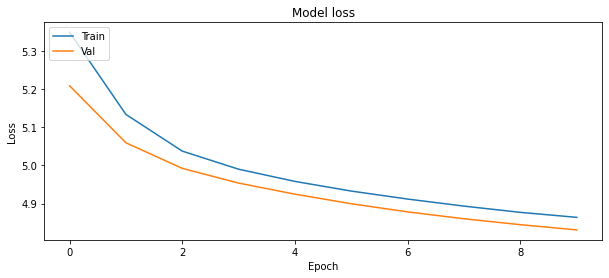

255/255 [==============================] - 3s 9ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
                                 precision    recall  f1-score   support

                            311       0.00      0.00      0.00        22
                        50 cent       0.00      0.00      0.00        52
                          ac dc       0.00      0.00      0.00        22
                   adam lambert       0.00      0.00      0.00        28
                      aerosmith       0.00      0.00      0.00        27
                            afi       0.00      0.00      0.00        21
                           akon       0.00      0.00      0.00        68
              alanis morissette       0.00      0.00      0.00        21
                   alice cooper       0.00      0.00      0.00        62
                    alicia keys       0.00      0.00      0.00        31
                   al

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_fromtask1_model_5"

def print_model_details(model):
  print("^"*80)
  print(f"{model.name}")
  for layer in model.layers:
      x = 20
      print(f"   {layer.name[:x].ljust(x)} {layer.__class__.__name__[:x].ljust(x)} {str(layer.trainable)[:x].ljust(x)}")
  print("^"*80)

base_name = "train_model_LSTM_with_embedding_pretrained_glove"
base_model = tf.keras.models.load_model(os.path.join(WORKDIR, base_name))

base_model.summary()
print_model_details(base_model)
for layer in base_model.layers:
    if layer.name == "dense_40":
        layer.trainable = True   
    elif layer.name == "dropout_18":
        layer.trainable = True   
    else:
        layer.trainable = False 
base_model.summary()
print_model_details(base_model)

print("-"*60)
print("Create new model on top:")
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(base_model)
model.add(tf.keras.layers.Dense(235, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])


model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
print_model_details(model)
    
history = model.fit(x=train_lyrics,
                    y=train_artists,
                    validation_data=(val_lyrics, val_artists), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))

test_lyrics, test_artists = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_artists,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_artists, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_artists, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_artists, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_artists, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_artists, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_artists, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())

## Remove the Dense(10) layer from the pre-trained model

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 200, 100)          1000200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,034,898
Trainable params: 34,698
Non-

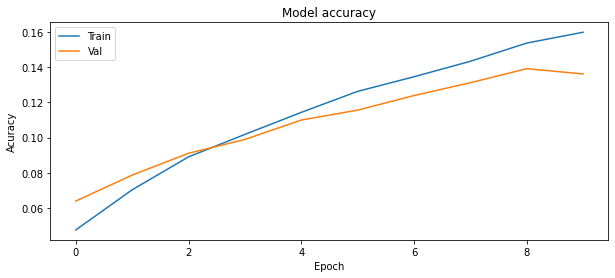

255/255 [==============================] - 3s 9ms/step
[[ 2  0  0 ...  0  0  0]
 [ 0 28  0 ...  0  1  1]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  2 ...  2  0  0]
 [ 0  2  0 ...  0  4  0]
 [ 0  2  0 ...  0  0  9]]
                                 precision    recall  f1-score   support

                            311       0.10      0.09      0.10        22
                        50 cent       0.28      0.54      0.37        52
                          ac dc       0.17      0.18      0.17        22
                   adam lambert       0.12      0.04      0.06        28
                      aerosmith       0.00      0.00      0.00        27
                            afi       0.00      0.00      0.00        21
                           akon       0.24      0.43      0.31        68
              alanis morissette       0.18      0.10      0.12        21
                   alice cooper       0.14      0.24      0.17        62
                    alicia keys       0.00      0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_fromtask1_model_5"

def print_model_details(model):
  print("^"*80)
  print(f"{model.name}")
  for layer in model.layers:
      x = 20
      print(f"   {layer.name[:x].ljust(x)} {layer.__class__.__name__[:x].ljust(x)} {str(layer.trainable)[:x].ljust(x)}")
  print("^"*80)

base_name = "train_model_LSTM_with_embedding_pretrained_glove"
base_model = tf.keras.models.load_model(os.path.join(WORKDIR, base_name))

base_model.summary()
print_model_details(base_model)
for layer in base_model.layers:
    if layer.name == "bidirectional_1":
        layer.trainable = True   
    elif layer.name == "dropout_18":
        layer.trainable = True   
    elif layer.name == "dense_40":
        layer.trainable = True   
    else:
        layer.trainable = False 
base_model.pop() # removing dense_40
base_model.pop() # removing dropout_18
base_model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])

base_model.summary()
print_model_details(base_model)


print("-"*60)
print("Create new model on top:")

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(base_model)
model.add(tf.keras.layers.Dense(235, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])


model.summary()
print_model_details(model)
    
history = model.fit(x=train_lyrics,
                    y=train_artists,
                    validation_data=(val_lyrics, val_artists), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                            patience=30, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


test_lyrics, test_artists = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_artists,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_artists, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_artists, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_artists, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_artists, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_artists, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_artists, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())

# 2. Model 2 from Task 1 (the CNN with oversampling)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,065,418
Trainable params: 1,065,418
No

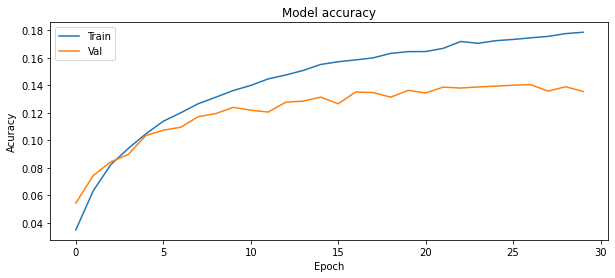

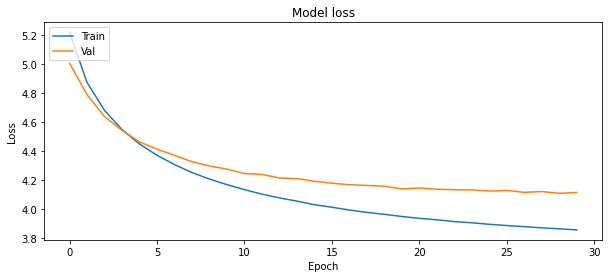

255/255 [==============================] - 1s 4ms/step
[[ 0  0  0 ...  0  0  2]
 [ 0 25  0 ...  0  4  2]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  1  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  1]]
                                 precision    recall  f1-score   support

                            311       0.00      0.00      0.00        22
                        50 cent       0.35      0.48      0.41        52
                          ac dc       0.00      0.00      0.00        22
                   adam lambert       0.17      0.04      0.06        28
                      aerosmith       0.00      0.00      0.00        27
                            afi       0.00      0.00      0.00        21
                           akon       0.47      0.37      0.41        68
              alanis morissette       0.27      0.19      0.22        21
                   alice cooper       0.04      0.02      0.02        62
                    alicia keys       0.10      0.03      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_fromtask1_model_10a"

def print_model_details(model):
  print("^"*80)
  print(f"{model.name}")
  for layer in model.layers:
      x = 20
      print(f"   {layer.name[:x].ljust(x)} {layer.__class__.__name__[:x].ljust(x)} {str(layer.trainable)[:x].ljust(x)}")
  print("^"*80)

base_name = "train_model_embedding_with_cnn_sampler_over"
base_model = tf.keras.models.load_model(os.path.join(WORKDIR, base_name))

base_model.summary()
print_model_details(base_model)
for layer in base_model.layers:
    layer.trainable = False 
base_model.pop() # remove Dense(10)
base_model.summary()
print_model_details(base_model)
base_model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])


print("-"*60)
print("Create new model on top:")
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(base_model)
model.add(tf.keras.layers.Dense(235, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])


model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
print_model_details(model)
    
history = model.fit(x=train_lyrics,
                    y=train_artists,
                    validation_data=(val_lyrics, val_artists), 
                    batch_size=128,
                    epochs=30,
                    shuffle=True,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            patience=10, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


test_lyrics, test_artists = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_artists,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_artists, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_artists, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_artists, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_artists, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_artists, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_artists, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())


## Once more, with over sampling the training set

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,065,418
Trainable params: 1,065,418
No

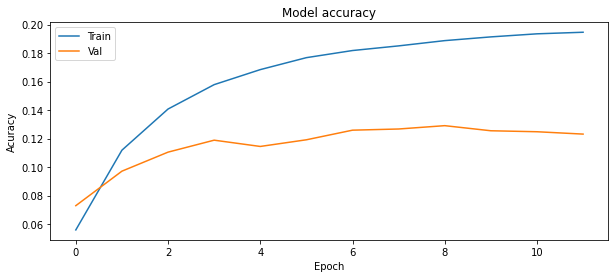

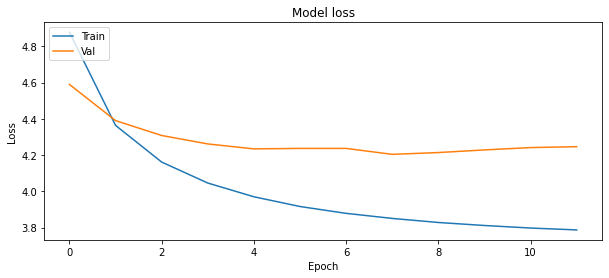

255/255 [==============================] - 1s 4ms/step
[[ 0  0  0 ...  0  0  1]
 [ 0 16  0 ...  0  2  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  2 ...  2  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0  0]]
                                 precision    recall  f1-score   support

                            311       0.00      0.00      0.00        22
                        50 cent       0.44      0.31      0.36        52
                          ac dc       0.00      0.00      0.00        22
                   adam lambert       0.08      0.14      0.10        28
                      aerosmith       0.17      0.07      0.10        27
                            afi       0.02      0.05      0.03        21
                           akon       0.65      0.32      0.43        68
              alanis morissette       0.11      0.05      0.07        21
                   alice cooper       0.07      0.02      0.03        62
                    alicia keys       0.12      0.10      

In [20]:
with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_fromtask1_model_10a"

def print_model_details(model):
  print("^"*80)
  print(f"{model.name}")
  for layer in model.layers:
      x = 20
      print(f"   {layer.name[:x].ljust(x)} {layer.__class__.__name__[:x].ljust(x)} {str(layer.trainable)[:x].ljust(x)}")
  print("^"*80)

base_name = "train_model_embedding_with_cnn_sampler_over"
base_model = tf.keras.models.load_model(os.path.join(WORKDIR, base_name))

base_model.summary()
print_model_details(base_model)
for layer in base_model.layers:
    layer.trainable = False 
base_model.pop() # remove Dense(10)
base_model.summary()
print_model_details(base_model)
base_model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])


print("-"*60)
print("Create new model on top:")
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(base_model)
model.add(tf.keras.layers.Dense(235, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])


model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
print_model_details(model)
    

with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_scratch_extra"


from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
print("Before resampling:", train_lyrics.shape, train_artists.shape, np.unique(train_artists, return_counts=True))
X_res, y_res = rus.fit_resample(np.expand_dims(train_lyrics, axis=1), np.expand_dims(train_artists, axis=1))
train_lyrics = np.squeeze(X_res)
train_artists = np.squeeze(y_res)
print("After resampling:", train_lyrics.shape, train_artists.shape, np.unique(train_artists, return_counts=True))


history = model.fit(x=train_lyrics,
                    y=train_artists,
                    validation_data=(val_lyrics, val_artists), 
                    batch_size=128,
                    epochs=12,
                    shuffle=True,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            patience=6, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


test_lyrics, test_artists = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_artists,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_artists, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_artists, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_artists, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_artists, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_artists, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_artists, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())


# 3. Model from scratch 

Before resampling: (65404,) (65404,) (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172,

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


2360/2360 [==============================] - 64s 27ms/step - loss: 4.3740 - accuracy: 0.1243 - val_loss: 3.9692 - val_accuracy: 0.2398
Epoch 2/10
2359/2360 [============================>.] - ETA: 0s - loss: 2.9615 - accuracy: 0.3566
Epoch 2: val_loss improved from 3.96918 to 3.46592, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


2360/2360 [==============================] - 62s 26ms/step - loss: 2.9614 - accuracy: 0.3566 - val_loss: 3.4659 - val_accuracy: 0.3401
Epoch 3/10
2358/2360 [============================>.] - ETA: 0s - loss: 2.3063 - accuracy: 0.4813
Epoch 3: val_loss improved from 3.46592 to 3.22018, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


2360/2360 [==============================] - 62s 26ms/step - loss: 2.3062 - accuracy: 0.4814 - val_loss: 3.2202 - val_accuracy: 0.3870
Epoch 4/10
2358/2360 [============================>.] - ETA: 0s - loss: 1.9402 - accuracy: 0.5530
Epoch 4: val_loss improved from 3.22018 to 3.08740, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


2360/2360 [==============================] - 64s 27ms/step - loss: 1.9401 - accuracy: 0.5530 - val_loss: 3.0874 - val_accuracy: 0.4179
Epoch 5/10
2358/2360 [============================>.] - ETA: 0s - loss: 1.7049 - accuracy: 0.5998
Epoch 5: val_loss improved from 3.08740 to 3.02665, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


2360/2360 [==============================] - 62s 26ms/step - loss: 1.7050 - accuracy: 0.5997 - val_loss: 3.0266 - val_accuracy: 0.4364
Epoch 6/10
2359/2360 [============================>.] - ETA: 0s - loss: 1.5356 - accuracy: 0.6332
Epoch 6: val_loss improved from 3.02665 to 3.00811, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch/assets


2360/2360 [==============================] - 63s 27ms/step - loss: 1.5357 - accuracy: 0.6332 - val_loss: 3.0081 - val_accuracy: 0.4531
Epoch 7/10
2359/2360 [============================>.] - ETA: 0s - loss: 1.4153 - accuracy: 0.6581
Epoch 7: val_loss did not improve from 3.00811
2360/2360 [==============================] - 60s 26ms/step - loss: 1.4153 - accuracy: 0.6581 - val_loss: 3.0111 - val_accuracy: 0.4678
Epoch 8/10
2359/2360 [============================>.] - ETA: 0s - loss: 1.3245 - accuracy: 0.6774
Epoch 8: val_loss did not improve from 3.00811
2360/2360 [==============================] - 60s 25ms/step - loss: 1.3246 - accuracy: 0.6773 - val_loss: 3.0661 - val_accuracy: 0.4737
Epoch 9/10
2360/2360 [==============================] - ETA: 0s - loss: 1.2511 - accuracy: 0.6920
Epoch 9: val_loss did not improve from 3.00811
2360/2360 [==============================] - 60s 25ms/step - loss: 1.2511 - accuracy: 0.6920 - val_loss: 3.1402 - val_accuracy: 0.4754
Epoch 10/10
2359/2360 [==

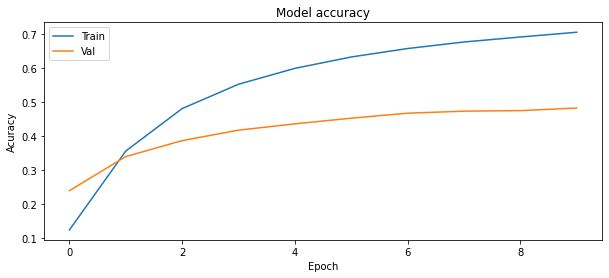

255/255 [==============================] - 1s 4ms/step
[[ 8  0  0 ...  1  0  1]
 [ 0 34  0 ...  0  1  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  2  0 ...  0 12  1]
 [ 0  0  0 ...  0  0 18]]
                                 precision    recall  f1-score   support

                            311       0.31      0.36      0.33        22
                        50 cent       0.65      0.65      0.65        52
                          ac dc       0.50      0.32      0.39        22
                   adam lambert       0.73      0.79      0.76        28
                      aerosmith       0.47      0.26      0.33        27
                            afi       0.60      0.29      0.39        21
                           akon       0.58      0.69      0.63        68
              alanis morissette       0.68      0.62      0.65        21
                   alice cooper       0.35      0.48      0.41        62
                    alicia keys       0.65      0.55      

In [17]:
with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_scratch"


from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
print("Before resampling:", train_lyrics.shape, train_artists.shape, np.unique(train_artists, return_counts=True))
X_res, y_res = rus.fit_resample(np.expand_dims(train_lyrics, axis=1), np.expand_dims(train_artists, axis=1))
train_lyrics = np.squeeze(X_res)
train_artists = np.squeeze(y_res)
print("After resampling:", train_lyrics.shape, train_artists.shape, np.unique(train_artists, return_counts=True))

with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_size,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Conv1D(256, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(235, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_artists,
                    validation_data=(val_lyrics, val_artists), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()




model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))

test_lyrics, test_artists = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_artists,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_artists, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_artists, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_artists, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_artists, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_artists, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_artists, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set_task2.pickle'), 'rb') as f:
    train_lyrics, train_artists, val_lyrics, val_artists = pickle.load(f)
save_name = "train_model_task_2_scratch_extra"


from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
print("Before resampling:", train_lyrics.shape, train_artists.shape, np.unique(train_artists, return_counts=True))
X_res, y_res = rus.fit_resample(np.expand_dims(train_lyrics, axis=1), np.expand_dims(train_artists, axis=1))
train_lyrics = np.squeeze(X_res)
train_artists = np.squeeze(y_res)
print("After resampling:", train_lyrics.shape, train_artists.shape, np.unique(train_artists, return_counts=True))

with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_size,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Conv1D(512, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(356, activation="softmax"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(235, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_artists,
                    validation_data=(val_lyrics, val_artists), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()




model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))

test_lyrics, test_artists = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_artists,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_artists, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories_task2.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_artists, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_artists, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_artists, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_artists, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_artists, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())

Before resampling: (65404,) (65404,) (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172,

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch_extra/assets


2360/2360 [==============================] - 67s 28ms/step - loss: 5.3520 - accuracy: 0.0075 - val_loss: 5.2218 - val_accuracy: 0.0088
Epoch 2/10
2358/2360 [============================>.] - ETA: 0s - loss: 5.2118 - accuracy: 0.0095
Epoch 2: val_loss improved from 5.22178 to 5.07862, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch_extra
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch_extra/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch_extra/assets


2360/2360 [==============================] - 67s 28ms/step - loss: 5.2118 - accuracy: 0.0095 - val_loss: 5.0786 - val_accuracy: 0.0144
Epoch 3/10
2359/2360 [============================>.] - ETA: 0s - loss: 5.0828 - accuracy: 0.0129
Epoch 3: val_loss improved from 5.07862 to 4.94634, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch_extra
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch_extra/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_task_2_scratch_extra/assets


2360/2360 [==============================] - 92s 39ms/step - loss: 5.0829 - accuracy: 0.0129 - val_loss: 4.9463 - val_accuracy: 0.0208
Epoch 4/10
 623/2360 [======>.......................] - ETA: 46s - loss: 5.0060 - accuracy: 0.0153